In [1]:
import sys
import os
import matplotlib.pyplot as plt
import copy
import math
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.io import write_image

In [2]:
import tensorflow as tf
import keras
from keras import initializers
from keras.layers import Input, Dropout, BatchNormalization, Conv3DTranspose, concatenate, Dense, Conv3D, Flatten, MaxPooling3D
from keras.models import Sequential
import keras.backend as K
tf.keras.utils.set_random_seed(0)

In [3]:
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.chdir("CNN_PBX_Model")

Num GPUs Available:  1


In [5]:
# TRAINING DATA

paths = [x[0] for x in os.walk('train/')][1:]

train_data = []
train_labels = []

for i in paths:
  train_ex = np.load(i + "/input.npy")

  if train_ex.shape != (16,34,34):

    first_axis_pad = int(0.5 * (34 - train_ex.shape[1]))
    second_axis_pad = int(0.5 * (34 - train_ex.shape[2]))

    train_ex = np.pad(train_ex, ((0, 0), (first_axis_pad, first_axis_pad), (second_axis_pad, second_axis_pad), (0,0)), 'wrap')

  train_lb = np.load(i + "/output.npy")
  train_data.append(train_ex)
  train_labels.append(train_lb)

train_data = np.array(train_data)
train_labels = np.array(train_labels) / 1000

print(train_data.shape)
print(train_labels.shape)

(64, 16, 34, 34, 3)
(64, 16, 32, 32, 1)


In [6]:
# VALIDATION DATA

validation_paths = [x[0] for x in os.walk('validation/')][1:]

validation_data = []
validation_labels = []

for i in validation_paths:
  validation_ex= np.load(i + "/input.npy")

  if validation_ex.shape != (16,34,34):

    first_axis_pad = int(0.5 * (34 - validation_ex.shape[1]))
    second_axis_pad = int(0.5 * (34 - validation_ex.shape[2]))

    validation_ex = np.pad(validation_ex, ((0, 0), (first_axis_pad, first_axis_pad), (second_axis_pad, second_axis_pad), (0,0)), 'wrap')


  validation_lb = np.load(i + "/output.npy")
  validation_data.append(validation_ex)
  validation_labels.append(validation_lb)

validation_data = np.array(validation_data)
validation_labels = np.array(validation_labels) / 1000

print(validation_data.shape)
print(validation_labels.shape)

(28, 16, 34, 34, 3)
(28, 16, 32, 32, 1)


In [7]:
def periodic_padding_flexible(tensor, axis, padding=1):

    if isinstance(axis,int):
        axis = (axis,)
    if isinstance(padding,int):
        padding = (padding,)

    ndim = len(tensor.shape)

    for ax,p in zip(axis,padding):
        # create a slice object that selects everything from all axes,
        # except only 0:p for the specified for right, and -p: for left

        ind_right = [slice(-p,None) if i == ax else slice(None) for i in range(ndim)]
        ind_left = [slice(0, p) if i == ax else slice(None) for i in range(ndim)]
        right = tensor[ind_right]
        left = tensor[ind_left]
        middle = tensor
        tensor = tf.concat([right,middle,left], axis=ax)

    return tensor

In [8]:
def DownConvBlock(inputs, n_filters=32, filter_size = 3, max_pooling=True, special_padding=False):

  padding_size = int((filter_size-1)/2)
  kernel_init =   tf.keras.initializers.GlorotUniform(seed=0)
  bias_init = tf.keras.initializers.Zeros()


  # PERIODIC PADDING

  inputs = periodic_padding_flexible(inputs, axis=1,padding=padding_size)
  if special_padding == False:
    inputs = periodic_padding_flexible(inputs, axis=2,padding=padding_size)
    inputs = periodic_padding_flexible(inputs, axis=3,padding=padding_size)
  
  conv = Conv3D(n_filters, filter_size, activation='relu', padding='valid', kernel_initializer=kernel_init, bias_initializer=bias_init)(inputs)
  print(conv.shape)
  conv = periodic_padding_flexible(conv, axis=(1,2,3),padding=(padding_size,padding_size,padding_size))
  conv = Conv3D(n_filters, filter_size, activation='relu', padding='valid', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv)
  print(conv.shape)
  conv = BatchNormalization()(conv, training=False)
      
  if max_pooling:
    next_layer = tf.keras.layers.MaxPooling3D(pool_size = (2,2,2))(conv)
  else:
    next_layer = conv
  
  skip_connection = conv   

  print("end_of_block") 
  return next_layer, skip_connection

In [9]:
def UpConvBlock(prev_layer_input, skip_layer_input, filter_size = 3, n_filters=32):

    padding_size = int((filter_size-1)/2)
    kernel_init = tf.keras.initializers.GlorotUniform(seed=0)
    bias_init = tf.keras.initializers.Zeros()   

    up = Conv3DTranspose(n_filters, (filter_size,filter_size,filter_size),
                         strides=(filter_size-1,filter_size-1,filter_size-1),
                         padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init)(prev_layer_input)

    merge = concatenate([up, skip_layer_input], axis=4)
    merge = periodic_padding_flexible(merge, axis=(1,2,3),padding=(padding_size,padding_size,padding_size))
    conv = Conv3D(n_filters, filter_size, activation='relu', padding='valid', kernel_initializer=kernel_init,  bias_initializer=bias_init)(merge)
    print(conv.shape)
    conv = periodic_padding_flexible(conv, axis=(1,2,3),padding=(padding_size,padding_size,padding_size))
    conv = Conv3D(n_filters, filter_size, activation='relu',padding='valid', kernel_initializer=kernel_init,  bias_initializer=bias_init)(conv)
    print(conv.shape)

    print("end_of_block")
    return conv

In [10]:

def UNet3DModel(input_size=(16, 34, 34, 3), n_filters=32, filter_size=3, n_classes=1):
  kernel_init =  tf.keras.initializers.GlorotUniform(seed=0)
  bias_init = tf.keras.initializers.Zeros()  
  
  inputs = Input(input_size)
  print("Inputs", inputs.shape)

  cblock0 = DownConvBlock(inputs,     n_filters = n_filters    , filter_size = filter_size, max_pooling=False, special_padding=True)
  print("CB0", cblock0[0].shape)

  cblock1 = DownConvBlock(inputs,     n_filters = n_filters    , filter_size = filter_size, max_pooling=True, special_padding=True)
  print("CB1", cblock1[0].shape)

  cblock2 = DownConvBlock(cblock1[0], n_filters = n_filters*2  , filter_size = filter_size, max_pooling=True, special_padding=False)
  print("CB2", cblock2[0].shape)
    
  cblock3 = DownConvBlock(cblock2[0], n_filters = n_filters*4  , filter_size = filter_size, max_pooling=True, special_padding=False)
  print("CB3", cblock3[0].shape)
  
  cblock4 = DownConvBlock(cblock3[0], n_filters = n_filters*8  , filter_size = filter_size, max_pooling=False, special_padding=False)
  print("CB4", cblock4[0].shape)


  print("------------------")

  ublock7 = UpConvBlock(cblock4[0]   , cblock3[1],  n_filters = n_filters * 4, filter_size = filter_size)
  print("UB7", ublock7.shape)
  
  ublock8 = UpConvBlock(ublock7   , cblock2[1],  n_filters = n_filters * 2, filter_size = filter_size)
  print("UB8", ublock8.shape)
  
  ublock9 = UpConvBlock(ublock8   , cblock1[1],  n_filters = n_filters, filter_size = filter_size)
  print("UB9", ublock9.shape)

  ublock9 = periodic_padding_flexible(ublock9, axis=(1,2,3),padding=(1,1,1))
  
  conv9 = Conv3D(n_filters, 3, activation='relu', padding='valid', kernel_initializer=kernel_init,  bias_initializer=bias_init)(ublock9)
  print("C9", conv9.shape)
  
  conv10 = Conv3D(n_classes, 1, padding='same', kernel_initializer=kernel_init,  bias_initializer=bias_init)(conv9)
  print("C10", conv10.shape)

  model = tf.keras.Model(inputs=inputs, outputs=conv10)  

  return model


In [11]:

def custom_mse(y_true,y_pred):
    w_hot = 5.0
    w_cold = 1.0
    cutoff = 1.8
    weightmat = tf.cast(tf.where(tf.greater(y_true, cutoff), w_hot, w_cold),float)
    loss = tf.cast(K.square(y_pred - y_true),float)
    loss = loss*weightmat
    loss = K.mean(loss)
    return loss

In [12]:
model = UNet3DModel(input_size=(16, 34, 34, 3), n_filters=32, filter_size = 3, n_classes=1)
optimizer = tf.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss=custom_mse, optimizer=optimizer, metrics=['mse'])

Inputs (None, 16, 34, 34, 3)
(None, 16, 32, 32, 32)
(None, 16, 32, 32, 32)
end_of_block
CB0 (None, 16, 32, 32, 32)
(None, 16, 32, 32, 32)
(None, 16, 32, 32, 32)
end_of_block
CB1 (None, 8, 16, 16, 32)
(None, 8, 16, 16, 64)
(None, 8, 16, 16, 64)
end_of_block
CB2 (None, 4, 8, 8, 64)
(None, 4, 8, 8, 128)
(None, 4, 8, 8, 128)
end_of_block
CB3 (None, 2, 4, 4, 128)
(None, 2, 4, 4, 256)
(None, 2, 4, 4, 256)
end_of_block
CB4 (None, 2, 4, 4, 256)
------------------
(None, 4, 8, 8, 128)
(None, 4, 8, 8, 128)
end_of_block
UB7 (None, 4, 8, 8, 128)
(None, 8, 16, 16, 64)
(None, 8, 16, 16, 64)
end_of_block
UB8 (None, 8, 16, 16, 64)
(None, 16, 32, 32, 32)
(None, 16, 32, 32, 32)
end_of_block
UB9 (None, 16, 32, 32, 32)
C9 (None, 16, 32, 32, 32)
C10 (None, 16, 32, 32, 1)


In [13]:
#early = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0.001, patience=200, verbose=0, mode="auto", baseline=None, restore_best_weights=True)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0.0005, patience=200, verbose=0, mode="auto", baseline=None, restore_best_weights=True)


def scheduler(epoch, lr):
  if epoch == 500:
    return lr /5
  else:
    return lr


scheduler_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)


history = model.fit(train_data, train_labels, epochs=1000, validation_data=(validation_data, validation_labels), callbacks=[early, scheduler_cb])

Epoch 1/1000
2/2 [==============================] - 18s 3s/step - loss: 1.7163 - mse: 1.2085 - val_loss: 0.9396 - val_mse: 0.6231 - lr: 5.0000e-04
Epoch 2/1000
2/2 [==============================] - 1s 651ms/step - loss: 0.7435 - mse: 0.4189 - val_loss: 18.3231 - val_mse: 17.6341 - lr: 5.0000e-04
Epoch 3/1000
2/2 [==============================] - 1s 675ms/step - loss: 9.4486 - mse: 8.9767 - val_loss: 0.6523 - val_mse: 0.3868 - lr: 5.0000e-04
Epoch 4/1000
2/2 [==============================] - 1s 657ms/step - loss: 0.8536 - mse: 0.4902 - val_loss: 0.9399 - val_mse: 0.6220 - lr: 5.0000e-04
Epoch 5/1000
2/2 [==============================] - 1s 643ms/step - loss: 1.0751 - mse: 0.6679 - val_loss: 1.0296 - val_mse: 0.6972 - lr: 5.0000e-04
Epoch 6/1000
2/2 [==============================] - 1s 644ms/step - loss: 1.1499 - mse: 0.7294 - val_loss: 1.0715 - val_mse: 0.7327 - lr: 5.0000e-04
Epoch 7/1000
2/2 [==============================] - 1s 641ms/step - loss: 1.1845 - mse: 0.7581 - val_loss:

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


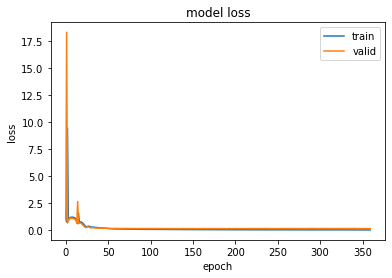

In [14]:
print(history.history.keys())
# # summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0,0.2])
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [18]:
from matplotlib import figure
def area_hotspot(datapoint):
  tinc = 5
  tnum = int(4500/tinc)

  tinc = 5
  tnum = int(4500/tinc)

  bins=np.zeros((tnum,2))
  bins[:,0] = [ tinc*(0.5 + x) for x in list(range(tnum))]

  for bin_index, temp in np.ndenumerate(datapoint):
    theta = temp * 1000
    tind=math.floor(theta/tinc)
    bins[:tind, 1] += 4 # ~ Roughly 2*2*1 nm^3 (volume value from Chunyu)
  
  return bins

def datapoint_results_print(simulation_point, simulation_temperatures):

  # Simulation point is the input train_data[<point order>,<dim 0>,<dim 1>,<dim 2>,<channel>]
  # For example, simulation_point = train_data[i,:,:,:,:]



  fig = make_subplots(rows=3, cols=3, specs=[[{"type": "scatter3d"},{"type": "scatter3d"},{"type": "scatter3d"}],
                                             [{"type": "scatter3d"},{"type": "scatter3d"},{"type": "scatter"}],
                                             [{"type": "histogram"},{"type": "histogram"},{"type": "scatter"}]],
                      subplot_titles=["Input 1","Input 2","Input 3",
                                      "Temp (Labels)","Temp (Predictions)","Parity Plot",
                                      "Temp (Distributions)", "Residuals", "Hotspot volume"], horizontal_spacing = 0.1, vertical_spacing = 0.1)
  
  fig.update_layout(autosize=False, width=1000, height=1000) 

  # FIRST PLOT --> INPUT 1

  input_1 = simulation_point[:,:,:,0].squeeze()

  X,Y,Z = np.mgrid[0:input_1.shape[2], 0:input_1.shape[1], 0:input_1.shape[0]]
  input_1_xz = np.swapaxes(input_1, 2, 0)

  trace_1 = go.Scatter3d(x = X.flatten(), y = Y.flatten(), z=Z.flatten(),
                          mode='markers', marker=dict(colorscale='Viridis', symbol='square', color = input_1_xz.flatten(), colorbar=dict(thickness=20, len=0.3, x=0.27, y=0.9)), showlegend=False)
  fig.add_trace(trace_1, row=1, col=1)

  # SECOND PLOT --> INPUT 2

  input_2 = simulation_point[:,:,:,1].squeeze()

  X,Y,Z = np.mgrid[0:input_2.shape[2], 0:input_2.shape[1], 0:input_2.shape[0]]
  input_2_xz = np.swapaxes(input_2, 2, 0)

  trace_2 = go.Scatter3d(x = X.flatten(), y = Y.flatten(), z=Z.flatten(),
                          mode='markers', marker=dict(colorscale='Viridis', symbol='square', color = input_2_xz.flatten(), colorbar=dict(thickness=20, len=0.3, x=0.62, y=0.9)), showlegend=False)
  fig.add_trace(trace_2, row=1, col=2)


  # THIRD PLOT --> INPUT 3

  input_3 = simulation_point[:,:,:,2].squeeze()

  X,Y,Z = np.mgrid[0:input_3.shape[2], 0:input_3.shape[1], 0:input_3.shape[0]]
  input_3_xz = np.swapaxes(input_3, 2, 0)

  trace_3 = go.Scatter3d(x = X.flatten(), y = Y.flatten(), z=Z.flatten(),
                          mode='markers', marker=dict(colorscale='Viridis', symbol='square', color = input_3_xz.flatten(), colorbar=dict(thickness=20, len=0.3, x=1, y=0.9)), showlegend=False)
  fig.add_trace(trace_3, row=1, col=3)

  # FOURTH PLOT --> TEMPS (LABELS)

  X,Y,Z = np.mgrid[0:simulation_temperatures.shape[2], 0:simulation_temperatures.shape[1], 0:simulation_temperatures.shape[0]]
  simulation_temperatures_xz = np.swapaxes(simulation_temperatures, 2, 0)

  trace_4 = go.Scatter3d(x = X.flatten(), y = Y.flatten(), z=Z.flatten(),
                          mode='markers', marker=dict(colorscale='Viridis', symbol='square', color = simulation_temperatures_xz.flatten(), colorbar=dict(thickness=20,len=0.3, x=0.27, y=0.5)), showlegend=False)
  fig.add_trace(trace_4, row=2, col=1)


  # FIFTH PLOT --> TEMPS (PREDICTIONS)

  pred = tf.expand_dims(simulation_point, axis=0)
  prediction_point = model.predict(pred)
  prediction_tensor = prediction_point.squeeze()

  X,Y,Z = np.mgrid[0:prediction_tensor.shape[2], 0:prediction_tensor.shape[1], 0:prediction_tensor.shape[0]]
  prediction_tensor_xz = np.swapaxes(prediction_tensor, 2, 0)

  trace_5 = go.Scatter3d(x = X.flatten(), y = Y.flatten(), z=Z.flatten(),
                          mode='markers', marker=dict(colorscale='Viridis', symbol='square', color = prediction_tensor_xz.flatten(), colorbar=dict(thickness=20, len=0.3, x=0.62, y=0.5)), showlegend=False)
  fig.add_trace(trace_5, row=2, col=2)

  # SIXTH PLOT --> PARITY PLOT

  trace_6 = go.Scatter(x=simulation_temperatures.flatten(), y = prediction_tensor.flatten(), mode='markers', showlegend=False)
  fig.add_trace(trace_6, row=2, col=3)
  fig.update_xaxes(title="Scaled Temperature (K) - Labels", row=2, col=3)
  fig.update_yaxes(title="Scaled Temperature (K) - Predictions", row=2, col=3)


  # SEVENTH PLOT --> TEMP (Distributions)

  trace_7 = go.Histogram(x=prediction_tensor.flatten(), name='Predictions', marker=dict(color='red'), showlegend=True, legendgroup = '1')
  trace_7b = go.Histogram(x=simulation_temperatures.flatten(), name='Truth', marker=dict(color='green'), showlegend=True, legendgroup = '1')
  fig.update_xaxes(title="Temperature (K) - Labels", row=3, col=1)
  fig.add_trace(trace_7, row=3, col=1)
  fig.add_trace(trace_7b, row=3, col=1) 


  # EIGHTH PLOT --> RESIDUALS

  diff_xz = prediction_tensor - simulation_temperatures
  flat_diff_xz = diff_xz.flatten()

  trace_8 = go.Histogram(x=flat_diff_xz, showlegend=False)
  trace_line = go.Scatter(x=[0,0], y = [0,700], mode='lines', showlegend=False)

  fig.add_trace(trace_8, row=3, col=2)
  fig.add_trace(trace_line, row=3, col=2)

  # NINTH PLOT ---> VOLUME OF HOTSPOT
  
  bins_labels = area_hotspot(simulation_temperatures)
  bins_predictions = area_hotspot(prediction_tensor)
  trace_9 = go.Scatter(x=bins_predictions[:,1], y=bins_predictions[:,0], mode='lines',  name='Predictions', marker=dict(color='red'), showlegend=True, legendgroup = '2')
  trace_9b = go.Scatter(x=bins_labels[:,1], y=bins_labels[:,0], mode='lines', name='Truth', marker=dict(color='green'), showlegend=True, legendgroup = '2')
  
  fig.add_trace(trace_9, row=3, col=3)
  fig.add_trace(trace_9b, row=3, col=3) 
  fig.update_xaxes(type="log", row=3, col=3)
  fig.update_xaxes(title="Hotspot Volume (nm^3)", row=3, col=3)
  fig.update_yaxes(title="Temperature (K)", row=3, col=3)  

  #### 

  fig.update_layout(autosize=False, width=1400, height=1000, legend_tracegroupgap = 180, legend=dict(font=dict(size=16),orientation="h"))      
  return fig



In [ ]:
for i in [0]:
  title = paths[i]
  inppoint = validation_data[0,:,:,:,:].squeeze()
  inplabel = validation_labels[0,:,:,:,:].squeeze()
  fig = datapoint_results_print(inppoint, inplabel)
  print(type(fig))
  write_image(fig, '/results/' + title + '.pdf', format='pdf')